# Dataset

Human activity recognition(HAR) is a sensor dataset. The sensor is a wearable accelerometer mounted on the chest. It has three axis named X, Y, Z. The sampling frequency of the accelerometer is 52Hz. According to the sensor's value, we can identify, the activity of human being. The dataset is gathered from 15 participants and the number of activities are 7. 

There are 15 files in the dataset. One from each participant and each file contains 5 columns, the row number, x, y, and z accelerometer readings and a class number from 0 to 7, where class 0 means “no activity” and classes 1-7 correspond to the activities listed below:

1: Working at Computer

2: Standing Up, Walking and Going up\down stairs

3: Standing

4: Walking

5: Going Up\Down Stairs

6: Walking and Talking with Someone

7: Talking while Standing

       

   
https://www.kaggle.com/datasets/imsparsh/single-chestmounted-accelerometer

In [1]:
# load dataset
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings('ignore')
from os import listdir
from pandas import read_csv



# load sequence for each subject, returns a list of numpy arrays
def load_dataset(prefix=''):
    subjects = list()
    directory = prefix + 'HAR/'
    for name in listdir(directory):
        filename = directory + '/' + name
        if not filename.endswith('.csv'):
            continue
        df = read_csv(filename, header=None)
        # drop row number
        values = df.values[:, 1:]
        subjects.append(values)
    return subjects

# load
subjects = load_dataset()
print('Loaded %d Participants sensor''s values' % len(subjects))

#test_full = np.vstack((subjects[0:4]))
data = np.vstack((subjects))
print("The size of  data is " + str(data.shape))
#print("The size of test data is " + str(test_full.shape))
df = pd.DataFrame(data, columns = ['X_axis','Y_axis','Z_axis', 'Label'])
df.head(926896)

Loaded 15 Participants sensors values
The size of  data is (1926896, 4)


,X_axis,Y_axis,Z_axis,Label
0,1502.0,2215.0,2153.0,1.0
1,1667.0,2072.0,2047.0,1.0
2,1611.0,1957.0,1906.0,1.0
3,1601.0,1939.0,1831.0,1.0
4,1643.0,1965.0,1879.0,1.0
...,...,...,...,...
926891,2024.0,2414.0,1994.0,7.0
926892,2063.0,2395.0,1987.0,7.0
926893,2103.0,2371.0,1962.0,7.0
926894,2147.0,2361.0,1937.0,7.0


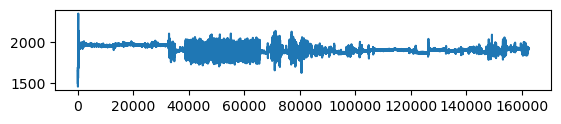

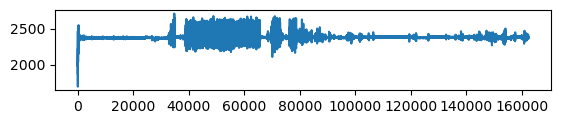

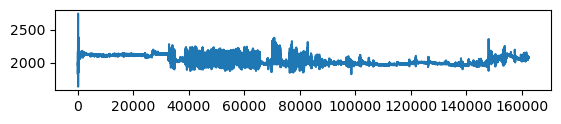

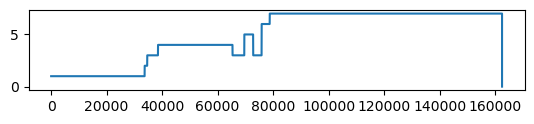

In [2]:
from matplotlib import pyplot
def plot_subject(subject):
    pyplot.figure()
    # create a plot for each column
    for col in range(subject.shape[1]):
        pyplot.subplot(subject.shape[1], 1, col+1)
        pyplot.plot(subject[:,col])
        pyplot.show()

plot_subject(subjects[0])

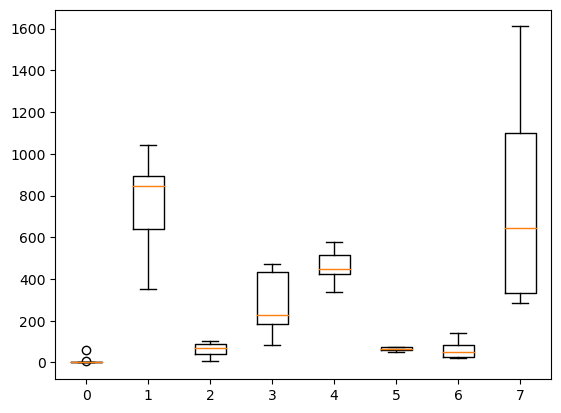

In [3]:
# returns a list of dict, where each dict has one sequence per activity
def group_by_activity(subjects, activities):
    grouped = [{a:s[s[:,-1]==a] for a in activities} for s in subjects]
    return grouped
 
# calculate total duration in sec for each activity per subject and plot
def plot_durations(grouped, activities):
    # calculate the lengths for each activity for each subject
    freq = 52
    durations = [[len(s[a])/freq for s in grouped] for a in activities]
    pyplot.boxplot(durations, labels=activities)
    pyplot.show()

# group traces by activity for each subject
activities = [i for i in range(0,8)]
grouped = group_by_activity(subjects, activities)
# plot durations
plot_durations(grouped, activities)

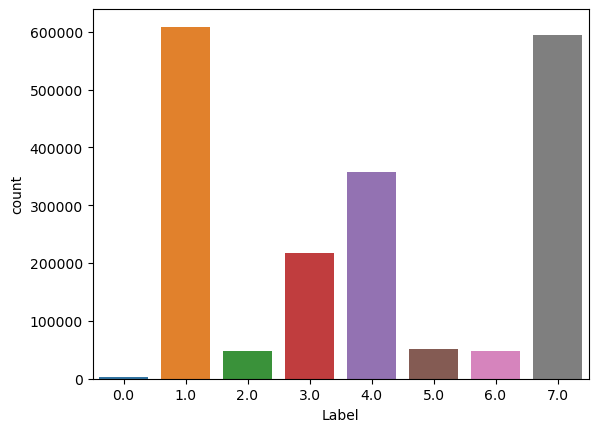

In [4]:
sns.countplot(data=df, x="Label")

# Data Cleaning 
Check if there is any NULL or missing value. As we can see below, there is no null values.

In [5]:
def get_missing_values(df):
    values = {}
    for feat in df.columns:
        if df[feat].isna().any():
            values[feat] = round(df[feat].mean(),2)
    return values

values = get_missing_values(df)
print('Missing values are:'+ str(values))
Sum = df.isnull().sum()
Percentage = ( df.isnull().sum()/df.isnull().count())
print('\n\nThe percentage and number of null values in each axis')
pd.concat([Sum,Percentage], axis =1, keys= ['Sum', 'Percentage'])

Missing values are:{}


The percentage and number of null values in each axis


,Sum,Percentage
X_axis,0,0.0
Y_axis,0,0.0
Z_axis,0,0.0
Label,0,0.0


# Sliding Windows

The sensor's values are taken at frequency of 52 Hz. It means 52 rows are recorded by accelerometer per second. The best approach to handle this time series problem is sliding windows. In sliding windows, we make an example using data points of few seconds. For instance, if we want to take values of 8 seconds then we'll pick 416 points at a time. For the next example/sample, we can either slide to next 416 points or we can overlap the few previous example points. I'm taking 50% overlapping.



In [6]:
from scipy import stats
def prep(data, window, step):

    x_list = []
    y_list = []
    z_list = []
    labels = []


    window_size = window
    step_size = step

    # creating overlaping windows of size window-size 100
    for i in range(0, data.shape[0] - window_size, step_size):
        x = data.iloc[i: i + window_size,0]
        y = data.iloc[i: i + window_size,1]
        z = data.iloc[i: i + window_size,2]
        label = stats.mode(data.iloc[i: i + window_size,3])[0][0]

        x_list.append(x)
        y_list.append(y)
        z_list.append(z)
        labels.append(label)
    
    return x_list,y_list, z_list, labels

In [7]:
frequency = 52
window_size = frequency*8
overlap = int(window_size/2)
x_list, y_list, z_list, Labels_list =  prep(df, window_size,overlap)

In [8]:
x_listt = np.array(x_list)
print('Sliding through X_axis gives number of samples:' +  str(x_listt.shape))
print('Sliding through Y_axis gives number of samples:' +  str(x_listt.shape))
print('Sliding through Z_axis gives number of samples:' +  str(x_listt.shape))
print('Sliding through labels and select the most occuring class gives:' +  str(len(Labels_list)))

print('\nCombining the examples from all the sensors, the final shape of the dataset will be:'+ '(' +str(x_listt.shape[0]) +','+ str(x_listt.shape[1]*4)+')' )

Sliding through X_axis gives number of samples:(9262, 416)
Sliding through Y_axis gives number of samples:(9262, 416)
Sliding through Z_axis gives number of samples:(9262, 416)
Sliding through labels and select the most occuring class gives:9262

Combining the examples from all the sensors, the final shape of the dataset will be:(9262,1664)


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.signal import find_peaks
import warnings
warnings.filterwarnings('ignore')
# Statistical Features on raw x, y and z in time domain
X_train = pd.DataFrame()

# mean
X_train['x_mean'] = pd.Series(x_list).apply(lambda x: x.mean())
X_train['y_mean'] = pd.Series(y_list).apply(lambda x: x.mean())
X_train['z_mean'] = pd.Series(z_list).apply(lambda x: x.mean())

# std dev
X_train['x_std'] = pd.Series(x_list).apply(lambda x: x.std())
X_train['y_std'] = pd.Series(y_list).apply(lambda x: x.std())
X_train['z_std'] = pd.Series(z_list).apply(lambda x: x.std())

"""# avg absolute diff
X_train['x_aad'] = pd.Series(x_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['y_aad'] = pd.Series(y_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['z_aad'] = pd.Series(z_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# min
X_train['x_min'] = pd.Series(x_list).apply(lambda x: x.min())
X_train['y_min'] = pd.Series(y_list).apply(lambda x: x.min())
X_train['z_min'] = pd.Series(z_list).apply(lambda x: x.min())

# max
X_train['x_max'] = pd.Series(x_list).apply(lambda x: x.max())
X_train['y_max'] = pd.Series(y_list).apply(lambda x: x.max())
X_train['z_max'] = pd.Series(z_list).apply(lambda x: x.max())

# max-min diff
X_train['x_maxmin_diff'] = X_train['x_max'] - X_train['x_min']
X_train['y_maxmin_diff'] = X_train['y_max'] - X_train['y_min']
X_train['z_maxmin_diff'] = X_train['z_max'] - X_train['z_min']

# median
X_train['x_median'] = pd.Series(x_list).apply(lambda x: np.median(x))
X_train['y_median'] = pd.Series(y_list).apply(lambda x: np.median(x))
X_train['z_median'] = pd.Series(z_list).apply(lambda x: np.median(x))

# median abs dev 
X_train['x_mad'] = pd.Series(x_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['y_mad'] = pd.Series(y_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['z_mad'] = pd.Series(z_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# interquartile range
X_train['x_IQR'] = pd.Series(x_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['y_IQR'] = pd.Series(y_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['z_IQR'] = pd.Series(z_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))"""

"""# negtive count
X_train['x_neg_count'] = pd.Series(x_list).apply(lambda x: np.sum(x < 0))
X_train['y_neg_count'] = pd.Series(y_list).apply(lambda x: np.sum(x < 0))
X_train['z_neg_count'] = pd.Series(z_list).apply(lambda x: np.sum(x < 0))

# positive count
X_train['x_pos_count'] = pd.Series(x_list).apply(lambda x: np.sum(x > 0))
X_train['y_pos_count'] = pd.Series(y_list).apply(lambda x: np.sum(x > 0))
X_train['z_pos_count'] = pd.Series(z_list).apply(lambda x: np.sum(x > 0))

# values above mean
X_train['x_above_mean'] = pd.Series(x_list).apply(lambda x: np.sum(x > x.mean()))
X_train['y_above_mean'] = pd.Series(y_list).apply(lambda x: np.sum(x > x.mean()))
X_train['z_above_mean'] = pd.Series(z_list).apply(lambda x: np.sum(x > x.mean()))"""

# number of peaks
X_train['x_peak_count'] = pd.Series(x_list).apply(lambda x: len(find_peaks(x)[0]))
X_train['y_peak_count'] = pd.Series(y_list).apply(lambda x: len(find_peaks(x)[0]))
X_train['z_peak_count'] = pd.Series(z_list).apply(lambda x: len(find_peaks(x)[0]))

# skewness
X_train['x_skewness'] = pd.Series(x_list).apply(lambda x: stats.skew(x))
X_train['y_skewness'] = pd.Series(y_list).apply(lambda x: stats.skew(x))
X_train['z_skewness'] = pd.Series(z_list).apply(lambda x: stats.skew(x))

# kurtosis
X_train['x_kurtosis'] = pd.Series(x_list).apply(lambda x: stats.kurtosis(x))
X_train['y_kurtosis'] = pd.Series(y_list).apply(lambda x: stats.kurtosis(x))
X_train['z_kurtosis'] = pd.Series(z_list).apply(lambda x: stats.kurtosis(x))


# energy
X_train['x_energy'] = pd.Series(x_list).apply(lambda x: np.sum(x**2)/window_size)
X_train['y_energy'] = pd.Series(y_list).apply(lambda x: np.sum(x**2)/window_size)
X_train['z_energy'] = pd.Series(z_list).apply(lambda x: np.sum(x**2/window_size))

In [10]:
X_train.shape

(9262, 18)

In [11]:
X_train.head()

,x_mean,y_mean,z_mean,x_std,y_std,z_std,x_peak_count,y_peak_count,z_peak_count,x_skewness,y_skewness,z_skewness,x_kurtosis,y_kurtosis,z_kurtosis,x_energy,y_energy,z_energy
0,1880.098558,2271.961538,2049.192308,187.727122,153.286167,135.816448,98,111,92,-0.368560,-1.074270,-0.126052,-0.798240,0.195621,1.719788,3.569927e+06,5.185249e+06,4.217591e+06
1,1959.889423,2373.353365,2119.915865,36.767289,31.935366,62.552995,102,107,92,-0.370111,-0.128232,0.830077,5.750125,7.692230,2.575066,3.842515e+06,5.633824e+06,4.497947e+06
2,1959.723558,2377.007212,2116.447115,10.108235,7.706824,16.596475,109,104,108,0.002457,-0.461198,-0.231989,0.944467,4.598112,0.668374,3.840618e+06,5.650223e+06,4.479623e+06
3,1955.550481,2379.911058,2105.769231,11.402065,8.181629,16.385995,98,100,96,0.298748,-0.279311,0.808923,1.000641,3.560760,1.903268,3.824307e+06,5.664043e+06,4.434532e+06
4,1959.329327,2379.706731,2107.593750,10.454247,6.356900,11.339699,109,108,98,-0.658759,0.661290,-0.367578,0.785470,2.393878,0.755356,3.839080e+06,5.663044e+06,4.442080e+06


In [12]:
def feature_normalize(dataset):

    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma

In [13]:
X_train_new = X_train.copy()
X_train_new = feature_normalize(X_train_new)

In [14]:
X_train_new.head()

,x_mean,y_mean,z_mean,x_std,y_std,z_std,x_peak_count,y_peak_count,z_peak_count,x_skewness,y_skewness,z_skewness,x_kurtosis,y_kurtosis,z_kurtosis,x_energy,y_energy,z_energy
0,-1.018692,-1.259485,0.912310,6.218945,3.193641,3.776251,-0.274806,0.460134,-0.417341,-0.593141,-1.577171,-0.289346,-0.444449,-0.246433,0.009448,-0.942365,-1.200943,0.976258
1,-0.262930,-0.104323,1.733102,0.498757,0.072626,1.269806,-0.102812,0.319175,-0.417341,-0.595114,-0.427327,0.866201,0.789503,0.581658,0.144598,-0.289095,-0.126018,1.817191
2,-0.264501,-0.062694,1.692845,-0.511411,-0.550507,-0.302431,0.198178,0.213456,0.270707,-0.121164,-0.832025,-0.417379,-0.116059,0.239875,-0.156696,-0.293640,-0.086721,1.762229
3,-0.304028,-0.029610,1.568921,-0.462385,-0.538295,-0.309632,-0.274806,0.072496,-0.245329,0.255754,-0.610953,0.840636,-0.105474,0.125287,0.038441,-0.332730,-0.053602,1.626977
4,-0.268235,-0.031938,1.590096,-0.498299,-0.585225,-0.482273,0.198178,0.354415,-0.159323,-0.962309,0.532283,-0.581248,-0.146020,-0.003609,-0.142951,-0.297326,-0.055996,1.649617


In [15]:
X_train_new.max()

x_mean           2.694225
y_mean           1.926763
z_mean           2.538159
x_std           13.327768
y_std           12.422697
z_std           17.171522
x_peak_count     1.660128
y_peak_count     1.552569
z_peak_count     1.818816
x_skewness      11.690525
y_skewness      17.276909
z_skewness      10.983176
x_kurtosis      26.262135
y_kurtosis      28.449946
z_kurtosis      34.769661
x_energy         3.106849
y_energy         2.010137
z_energy         2.702127
dtype: float64

In [16]:
values = get_missing_values(X_train_new)
print('Missing values are:'+ str(values))
Sum = X_train_new.isnull().sum()
Percentage = ( X_train_new.isnull().sum()/X_train_new.isnull().count())
print('\n\nThe percentage and number of null values in each axis')
pd.concat([Sum,Percentage], axis =1, keys= ['Sum', 'Percentage'])

Missing values are:{}


The percentage and number of null values in each axis


,Sum,Percentage
x_mean,0,0.0
y_mean,0,0.0
z_mean,0,0.0
x_std,0,0.0
y_std,0,0.0
z_std,0,0.0
x_peak_count,0,0.0
y_peak_count,0,0.0
z_peak_count,0,0.0
x_skewness,0,0.0


In [17]:
X_train_new['labels'] = Labels_list

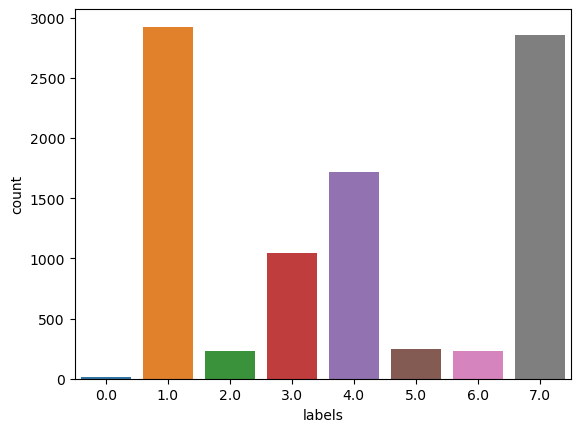

In [18]:
sns.countplot(data=X_train_new, x="labels")

# The dataset is highly imbalanced.

To solve this problem. First we'll remove the zero class(no activity). Then we'll use SMOTE to oversample the data.  

In [19]:
# Remove zero class
dell = X_train_new.index[X_train_new['labels'] == 0.0].tolist()
X_train_new.drop(dell, axis=0, inplace=True)

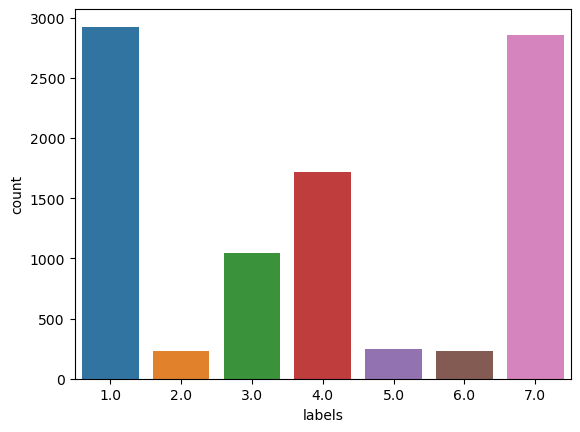

In [20]:
sns.countplot(data=X_train_new, x="labels")

# Oversample

In [21]:
# oversample and shuffle
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.utils import shuffle
def handle_imblanace_shuffle(data_x, data_y):
    
    counter = Counter(data_y)
    print("Unbalanced dataset ")
    print(counter)
    # define pipeline
    oversample = SMOTE()
    X, labels = oversample.fit_resample(data_x, data_y)
    # summarize the new class distribution
    counter = Counter(labels)
    print("\n\nBalanced dataset ")
    print(counter)
    #X_n, y_n = shuffle(X, labels)
    train_x_new = pd.concat([X, labels], axis=1, join="inner")
    return train_x_new


In [22]:
X_train_new_data = handle_imblanace_shuffle(X_train_new.loc[:, X_train_new.columns != 'labels'],X_train_new['labels'])

Unbalanced dataset 
Counter({1.0: 2925, 7.0: 2853, 4.0: 1716, 3.0: 1044, 5.0: 249, 2.0: 232, 6.0: 227})


Balanced dataset 
Counter({1.0: 2925, 2.0: 2925, 3.0: 2925, 4.0: 2925, 5.0: 2925, 6.0: 2925, 7.0: 2925})


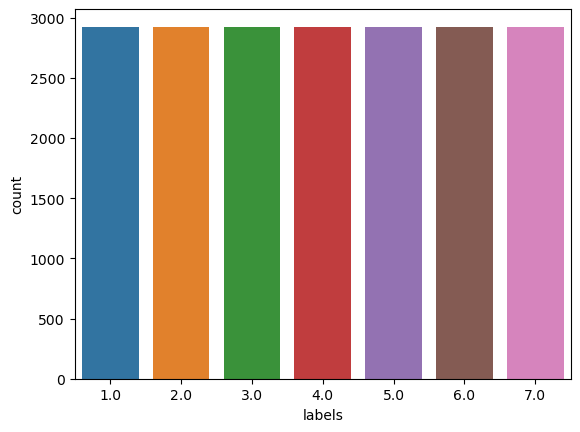

In [23]:
#labbb = pd.DataFrame(Y_balanced, columns = ['Labels'])
sns.countplot(data=X_train_new_data, x="labels")

In [24]:
X, Y= X_train_new_data.loc[:, X_train_new_data.columns != 'labels'].to_numpy(), X_train_new_data['labels'].to_numpy()
Y = Y-1

In [25]:
import xgboost as xgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.30, random_state=5)


model = XGBClassifier(n_estimators = 180, max_depth=8, learning_rate=0.1 ) 

model.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=180,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [26]:
import joblib
joblib.dump(model, 'model-deploy.joblib')

['model-deploy.joblib']

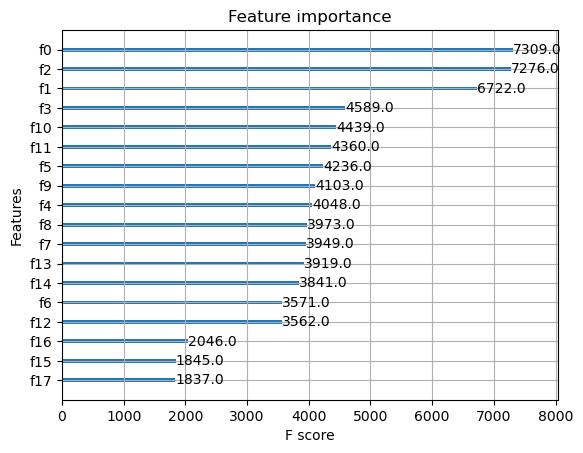

In [30]:
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(model)
pyplot.show()

In [31]:
X_test[0,None].shape

(1, 18)

In [33]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
encoder = LabelEncoder()
encoder.fit(y_test)
encoded_Y = encoder.transform(y_test)
dummy_y = np_utils.to_categorical(encoded_Y)


y_pred = model.predict(X_test) 

predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions) 

print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 94.51%


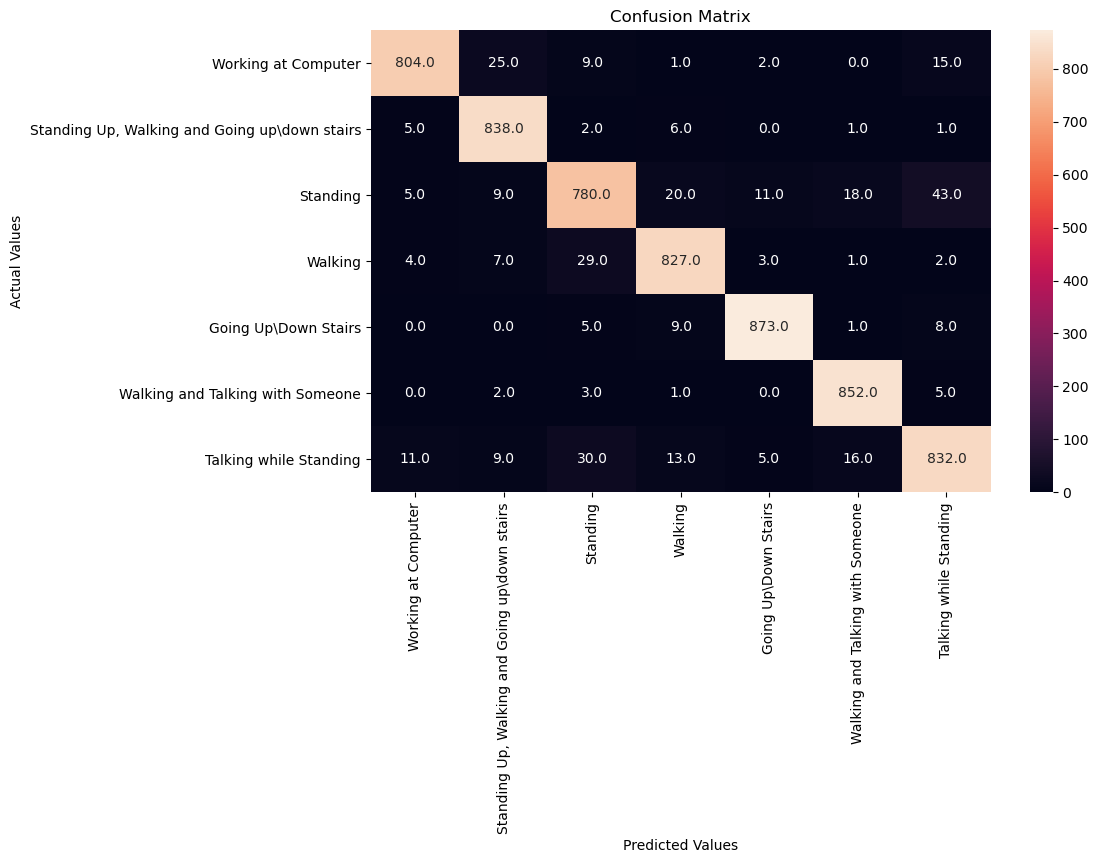

In [34]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index = ['Working at Computer','Standing Up, Walking and Going up\down stairs','Standing','Walking','Going Up\Down Stairs','Walking and Talking with Someone','Talking while Standing'], 
                     columns = ['Working at Computer','Standing Up, Walking and Going up\down stairs','Standing','Walking','Going Up\Down Stairs','Walking and Talking with Someone','Talking while Standing'])

#Plotting the confusion matrix
plt.figure(figsize=(10,6))
sns.heatmap(cm_df, annot=True, fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()


In [35]:
#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=[ 'Class 1', 'Class 2','Class 3', 'Class 4','Class 5', 'Class 6', 'Class 7']))


Accuracy: 0.95

Micro Precision: 0.95
Micro Recall: 0.95
Micro F1-score: 0.95

Macro Precision: 0.95
Macro Recall: 0.95
Macro F1-score: 0.95

Weighted Precision: 0.95
Weighted Recall: 0.95
Weighted F1-score: 0.94

Classification Report

              precision    recall  f1-score   support

     Class 1       0.97      0.94      0.95       856
     Class 2       0.94      0.98      0.96       853
     Class 3       0.91      0.88      0.89       886
     Class 4       0.94      0.95      0.95       873
     Class 5       0.98      0.97      0.98       896
     Class 6       0.96      0.99      0.97       863
     Class 7       0.92      0.91      0.91       916

    accuracy                           0.95      6143
   macro avg       0.95      0.95      0.95      6143
weighted avg       0.95      0.95      0.94      6143



# SVM


In [36]:
X, Y= X_train_new_data.loc[:, X_train_new_data.columns != 'labels'].to_numpy(), X_train_new_data['labels'].to_numpy()
Y = Y-1

In [37]:
import xgboost as xgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#Importing the necessary packages and libaries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets
import matplotlib.pyplot as plt
import numpy as np


X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.30, random_state=5)

rbf = svm.SVC(kernel='rbf', gamma=1, C=100, decision_function_shape='ovo').fit(X_train, y_train)
"""sig = svm.SVC(kernel='sigmoid', C=1, decision_function_shape='ovo').fit(X_train, y_train)
linear = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(X_train, y_train)
poly = svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo').fit(X_train, y_train)"""


from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
encoder = LabelEncoder()
encoder.fit(y_test)
encoded_Y = encoder.transform(y_test)
dummy_y = np_utils.to_categorical(encoded_Y)


y_pred = rbf.predict(X_test) 

predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions) 

print("Accuracy: %.2f%%" % (accuracy * 100.0))
#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=[ 'Class 1', 'Class 2','Class 3', 'Class 4','Class 5', 'Class 6', 'Class 7']))

Accuracy: 93.54%

Accuracy: 0.94

Micro Precision: 0.94
Micro Recall: 0.94
Micro F1-score: 0.94

Macro Precision: 0.94
Macro Recall: 0.94
Macro F1-score: 0.94

Weighted Precision: 0.94
Weighted Recall: 0.94
Weighted F1-score: 0.94

Classification Report

              precision    recall  f1-score   support

     Class 1       0.95      0.85      0.90       856
     Class 2       0.97      0.98      0.97       853
     Class 3       0.92      0.92      0.92       886
     Class 4       0.99      0.93      0.96       873
     Class 5       0.99      0.99      0.99       896
     Class 6       0.97      0.99      0.98       863
     Class 7       0.79      0.89      0.84       916

    accuracy                           0.94      6143
   macro avg       0.94      0.94      0.94      6143
weighted avg       0.94      0.94      0.94      6143



# DNN 

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
import keras
from keras.callbacks import EarlyStopping
# for modeling
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping

X, Y= X_train_new_data.loc[:, X_train_new_data.columns != 'labels'].to_numpy(), X_train_new_data['labels'].to_numpy()
Y = Y-1

# work with labels
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

print(dummy_y.shape)

# build a model
model = Sequential()
model.add(Dense(64, input_shape=(X.shape[1],), activation='relu')) 
model.add(Dense(64,  activation='relu'))
model.add(Dense(64,  activation='relu'))
model.add(Dense(7, activation='softmax'))
model.summary()

# compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])




# early stopping callback
# This callback will stop the training when there is no improvement in  
# the validation loss for 10 consecutive epochs.  
es = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                   mode='min',
                                   patience=10, 
                                   restore_best_weights=True) # important - otherwise you just return the last weigths...

# now we just update our model fit call
history = model.fit(X,
                    dummy_y,
                    callbacks=[es],
                    epochs=80, # you can set this to a big number!
                    batch_size=10,
                    shuffle=True,
                    validation_split=0.2,
                    verbose=1)

history_dict = history.history

# learning curve
# accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

# plot
# "r" is for "solid red line"
plt.plot(epochs, acc, 'r', label='Training accuracy')
# b is for "solid blue line"
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


(20475, 7)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                1216      
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 7)                 455       
                                                                 
Total params: 9,991
Trainable params: 9,991
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80
1638/1638 [==============================] - 10s 6ms/step - loss: 1.1251 - accuracy: 0.5734 - val_loss: 2.8626 - val_accuracy: 0.1639
Epoch 2/80
1638/1638 [======

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

preds = model.predict(X) # see how the model did!
print(preds[0]) # i'm spreading that prediction across three nodes and they sum to 1
print(np.sum(preds[0])) # sum it up! Should be 1


matrix = confusion_matrix(dummy_y.argmax(axis=1), preds.argmax(axis=1))

# more detail on how well things were predicted
print(classification_report(dummy_y.argmax(axis=1), preds.argmax(axis=1)))
